[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/peteyeh/celltrack/HEAD)

In [1]:
%matplotlib inline

import cv2
import matplotlib.colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import six

from collections import Counter, OrderedDict
from radiomics import featureextractor
from SimpleITK import GetImageFromArray
from skimage.filters import threshold_multiotsu
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

from displaytools import *
from improcessing import *

extractor = featureextractor.RadiomicsFeatureExtractor()
# Enable everything but shape (3D) and glcm.SumAverage
extractor.disableAllFeatures()
extractor.enableFeaturesByName(firstorder=[],
                               shape2D=[],
                               glcm=['Autocorrelation', 'JointAverage', 'ClusterProminence',
                                     'ClusterShade', 'ClusterTendency', 'Contrast',
                                     'Correlation', 'DifferenceAverage', 'DifferenceEntropy',
                                     'DifferenceVariance', 'JointEnergy', 'JointEntropy',
                                     'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn',
                                     'InverseVariance', 'MaximumProbability', 'SumEntropy',
                                     'SumSquares'],
                               glszm=[],
                               glrlm=[],
                               ngtdm=[],
                               gldm=[])

scaler = StandardScaler()
pca = PCA(n_components='mle')
kmeans = KMeans(n_clusters=2, random_state=0)
tsne = TSNE(learning_rate='auto', init='pca', random_state=0)

matplotlib_colors = ['yellow', 'red']

In [2]:
def crop_image(image):
    x, y, w, h = cv2.boundingRect(image)
    return image[y:y+h, x:x+w]

def display_classifications(image, centroids, labels):
    c = Counter(labels)
    for k in sorted(c):
        print("Class %s: %i (%.2f%%)" % (k, c[k], c[k]*100/sum(c.values())))
    plt.figure(dpi=240)
    plt.axis('off')
    plt.imshow(raw_image, interpolation='nearest', cmap='gray')
    plt.scatter(*zip(*centroids), s=20, c=labels, marker='+',
                cmap=matplotlib.colors.ListedColormap(matplotlib_colors), linewidths=1)
    plt.show()
    
def display_rois(image, masks, labels):
    for c in range(labels.min(), labels.max()+1):
        indices = np.where(labels==c)[0]
        print("Class %i, with %i ROIs:" % (c, len(indices)))
        masked = image*masks[indices]
        cropped = list(map(crop_image, masked))
        display_image_array(cropped, columns=10, dpi=300)

def display_tsne(df):
    transformed = tsne.fit_transform(df)
    plt.scatter(transformed[:,0], transformed[:,1], s=5, c=labels)
    plt.show()

def extract_features(raw_image, thresh_ks, C, close_ks):
    binarized = cv2.adaptiveThreshold(raw_image, 255,
                                      cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                      cv2.THRESH_BINARY_INV,
                                      thresh_ks, C)
    filled = apply_imfill(apply_closure(binarized, kernel_size=close_ks))

    num_components, labelled, stats, centroids = \
            cv2.connectedComponentsWithStats(filled, connectivity=8)

    features = OrderedDict()
    masks = []

    for i in range(1, len(stats)):  # index 0 is the background component
        size = stats[i, -1]
        if size < 75:
            continue
        mask = np.uint8(labelled == i)
        masks += [mask,]
        result = extractor.execute(GetImageFromArray(raw_image),
                                   GetImageFromArray(mask))
        if len(features) == 0:
            features['x'] = [int(centroids[i][0])]
            features['y'] = [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] = [val]
        else:
            features['x'] += [int(centroids[i][0])]
            features['y'] += [int(centroids[i][1])]
            for key, val in six.iteritems(result):
                if key.startswith("original_"):
                    features[key] += [val]

    return pd.DataFrame.from_dict(features).set_index(['x', 'y']), np.array(masks)

def process_features(df):
    return pd.DataFrame(pca.transform(scaler.transform(df.values)),
                        index=df.index)

# Test Image Pipeline

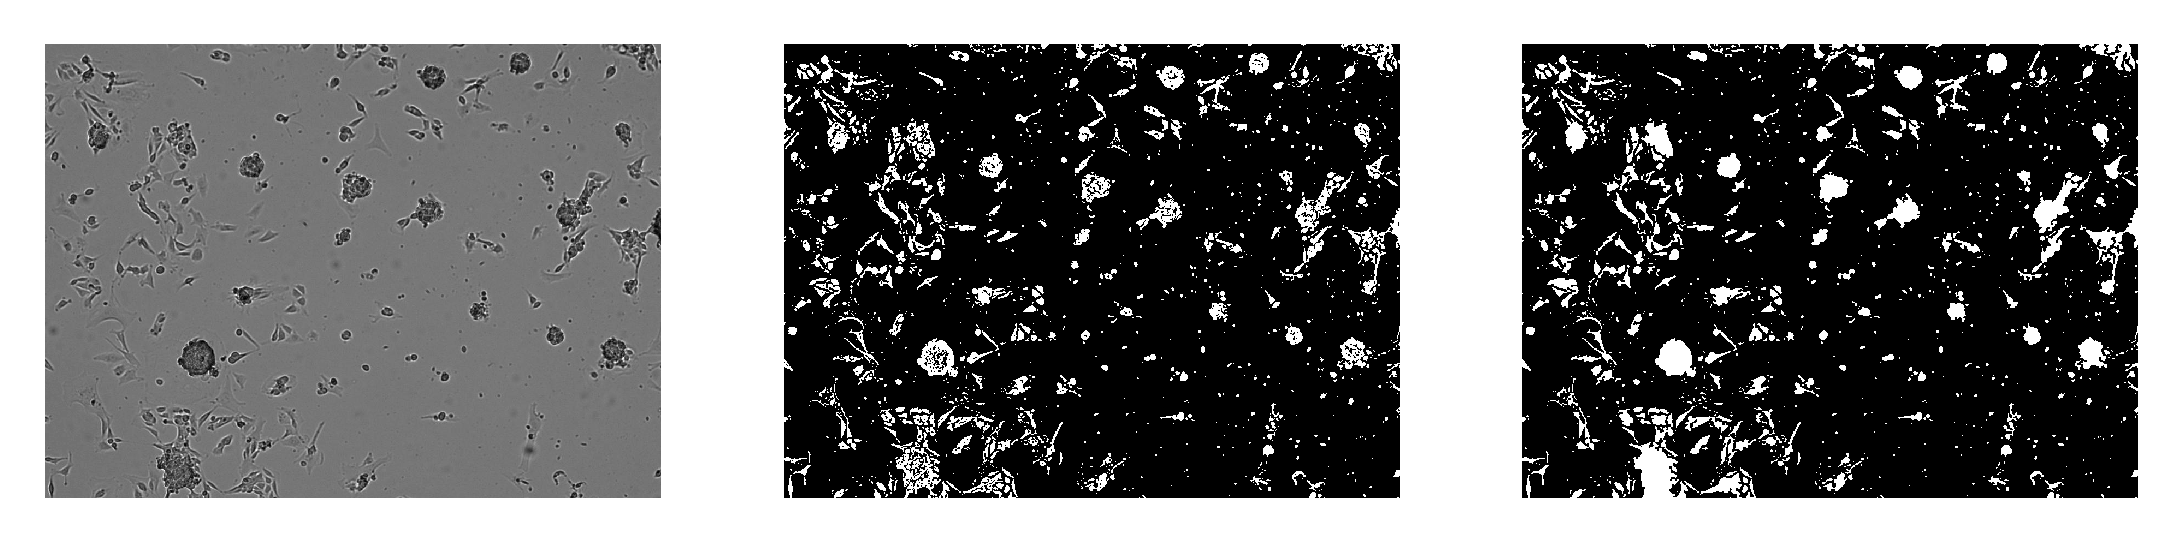

In [3]:
##### PARAMETERS #####
thresh_ks = 151
C = 8
close_ks = 3
######################

raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
binarized = cv2.adaptiveThreshold(raw_image, 255,
                                  cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  cv2.THRESH_BINARY_INV,
                                  thresh_ks, C)
filled = apply_imfill(apply_closure(binarized, kernel_size=close_ks))
display_image_array([raw_image, binarized, filled], columns=3, dpi=450)

# Fit and classify on control image

In [4]:
raw_image = cv2.imreadmulti('source_images/Control.tif')[1][0]
df, masks = extract_features(raw_image, thresh_ks, C, close_ks)
display(df)

scaler.fit(df.values)
pca.fit(df.values)
df = process_features(df)
display(df)

kmeans.fit(df)
labels = kmeans.predict(df)

original_shape2D_Elongation  original_shape2D_MajorAxisLength  \
x   y                                                                    
354 9                       0.263441                         39.823496   
476 3                       0.639776                         15.237390   
541 14                      0.512280                         31.564171   
575 3                       0.407083                         24.662635   
621 7                       0.813564                         15.754650   
...                              ...                               ...   
970 814                     0.651195                         40.629846   
177 810                     0.459414                         22.767687   
407 815                     0.585126                         14.952231   
169 824                     0.618327                         18.040935   
101 823                     0.386789                         27.783247   

        original_shape2D_MaximumDiameter original_shape2D_MeshSurface  \
x   y                                                                   
354 9                  33.61547262794322                        127.5   
476 3                  16.76305461424021                        103.5   
541 14                 30.01666203960727                        329.5   
575 3                 25.317977802344327                        180.5   
621 7                  16.15549442140351                        151.5   
...                                  ...                          ...   
970 814               39.824615503479755                        338.5   
177 810               25.553864678361276                        178.5   
407 815               15.033296378372908                         98.5   
169 824                             20.0                        140.5   
101 823                33.54101966249684                        217.5   

         original_shape2D_MinorAxisLength original_shape2D_Perimeter  \
x   y                                                                  
354 9                           10.491128          94.18376618407363   
476 3                            9.748512           43.7989898732233   
541 14                          16.169707          88.18376618407362   
575 3                           10.039748          65.79898987322329   
621 7                           12.817416          50.62741699796948   
...                                   ...                        ...   
970 814                         26.457971          167.5391052434012   
177 810                         10.459784          67.35533905932733   
407 815                          8.748934         41.798989873223306   
169 824                         11.155199         54.384776310850214   
101 823                         10.746261          83.35533905932735   

        original_shape2D_PerimeterSurfaceRatio  original_shape2D_PixelSurface  \
x   y                                                                           
354 9                       0.7386962053652834                          128.0   
476 3                       0.4231786461180995                          104.0   
541 14                      0.2676290324251096                          330.0   
575 3                       0.3645373400178576                          181.0   
621 7                      0.33417436962356095                          152.0   
...                                        ...                            ...   
970 814                     0.4949456580307273                          339.0   
177 810                     0.3773408350662596                          179.0   
407 815                     0.4243552271393229                           99.0   
169 824                    0.38708025844021504                          141.0   
101 823                     0.3832429382038039                          218.0   

         original_shape2D_Sphericity original_firstorder_10Percentile  ...  \
x   y                      

0             1            2          3          4   \
x   y                                                                    
354 9   -4.322277e+06 -16820.234747 -5887.421235 -37.161777 -44.527233   
476 3   -4.322278e+06 -16828.973014 -5889.832077 -29.423665 -40.251189   
541 14  -4.322277e+06 -16828.974270 -5889.764781 -29.250653 -40.322495   
575 3   -4.322277e+06 -16828.974247 -5889.878536 -29.407469 -40.184824   
621 7   -4.322278e+06 -16828.977524 -5890.020179 -29.251359 -40.380806   
...               ...           ...          ...        ...        ...   
970 814 -4.322277e+06 -16828.979063 -5890.087635 -29.139914 -40.529999   
177 810 -4.322277e+06 -16828.976142 -5889.957587 -29.311999 -40.279736   
407 815 -4.322277e+06 -16828.973424 -5889.873932 -29.495271 -40.064405   
169 824 -4.322277e+06 -16828.971087 -5889.776207 -29.613979 -39.977430   
101 823 -4.322277e+06 -16828.973044 -5889.704219 -29.309067 -40.252953   

                 5          6          7           8          9   ...  \
x   y                                                             ...   
354 9   -455.139682  23.882531  63.181871 -196.612093 -41.038229  ...   
476 3   -453.619386  26.389156  62.826776 -196.390258 -41.588744  ...   
541 14  -452.403355  26.228557  63.128197 -194.602405 -41.464712  ...   
575 3   -453.700292  26.302596  63.046412 -195.801227 -41.465868  ...   
621 7   -452.653455  26.456111  62.832449 -196.349467 -41.645344  ...   
...             ...        ...        ...         ...        ...  ...   
970 814 -451.228757  26.535426  63.203662 -195.530115 -41.218291  ...   
177 810 -453.540360  26.362309  63.008357 -195.910332 -41.479385  ...   
407 815 -454.641725  26.244282  62.849275 -195.930370 -41.464715  ...   
169 824 -454.430269  26.297442  63.061654 -196.395427 -41.413493  ...   
101 823 -452.879674  26.245528  62.857890 -194.814256 -41.403347  ...   

               87        88        89        90        91        92        93  \
x   y                                                                           
354 9    0.073165 -0.221284  0.943107  0.982242  0.262367 -0.844185  2.135907   
476 3    0.070035  0.090552  0.956247  0.012711 -0.795596  0.537791  0.796204   
541 14   0.167243  0.966970  0.345814 -0.818016  0.000105  0.956298  0.256288   
575 3    0.345476  0.461744  0.475797 -0.184549 -0.534527  0.976987  0.859712   
621 7    0.387527  0.213968  0.560778 -0.995622 -0.942937  0.867571  0.070352   
...           ...       ...       ...       ...       ...       ...       ...   
970 814 -0.275882 -0.491074  0.415679 -1.852938 -1.031805  0.220630 -0.330663   
177 810  0.136060 -0.376940  0.511503 -0.668385 -1.351058  0.849041  0.507825   
407 815  0.278035 -0.330984  0.542057  0.396892 -0.804041  0.772951  1.705181   
169 824  0.350231 -0.896703  0.941981  0.242913 -2.053911  0.488396  1.393023   
101 823  0.141144  0.705165  0.607521 -0.663432 -0.298319  0.632941  0.384415   

               94        95        96  
x   y                                  
354 9    0.681867 -0.524673 -0.110361  
476 3    0.296115  0.992881  0.195207  
541 14  -0.031105  1.379267  0.259207  
575 3    0.354708  0.960842  0.187487  
621 7    0.134453  1.661474  0.312251  
...           ...       ...       ...  
970 814 -0.197769  2.005289  0.376570  
177 810  0.344791  1.372084  0.267123  
407 815  0.827076  0.454498  0.089577  
169 824  0.773644  0.846372  0.174514  
101 823  0.013472  1.274997  0.238322  

[215 rows x 97 columns]

Class 0: 150 (69.77%)
Class 1: 65 (30.23%)


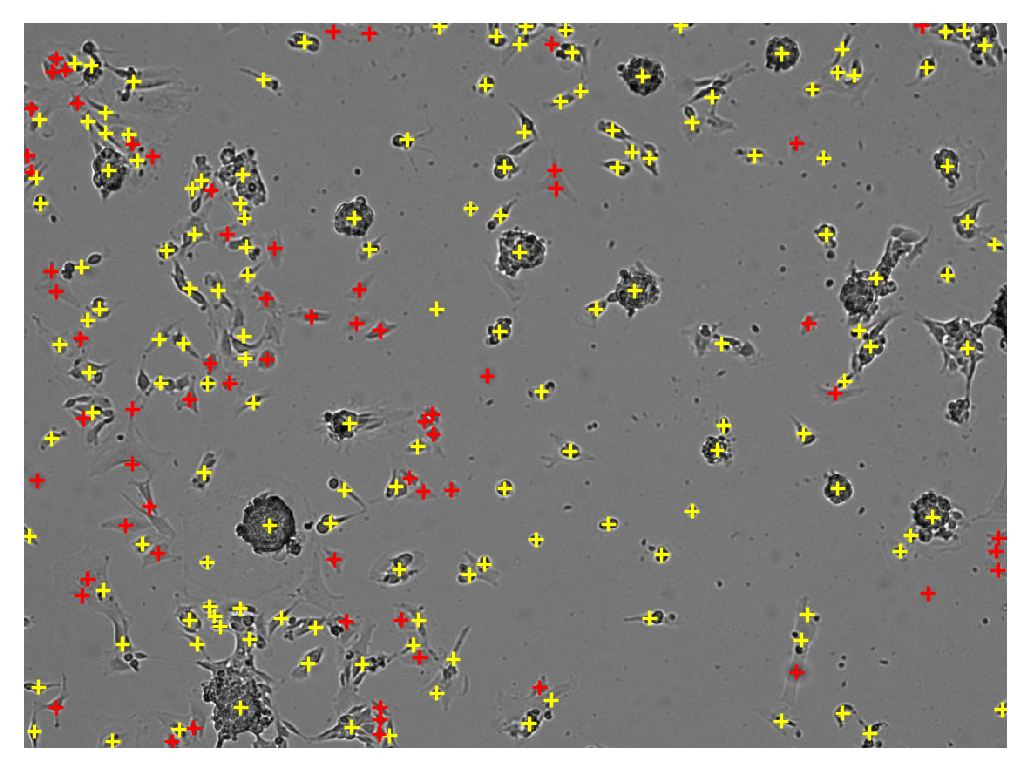

In [5]:
display_classifications(raw_image, df.index, labels)

Class 0, with 150 ROIs:


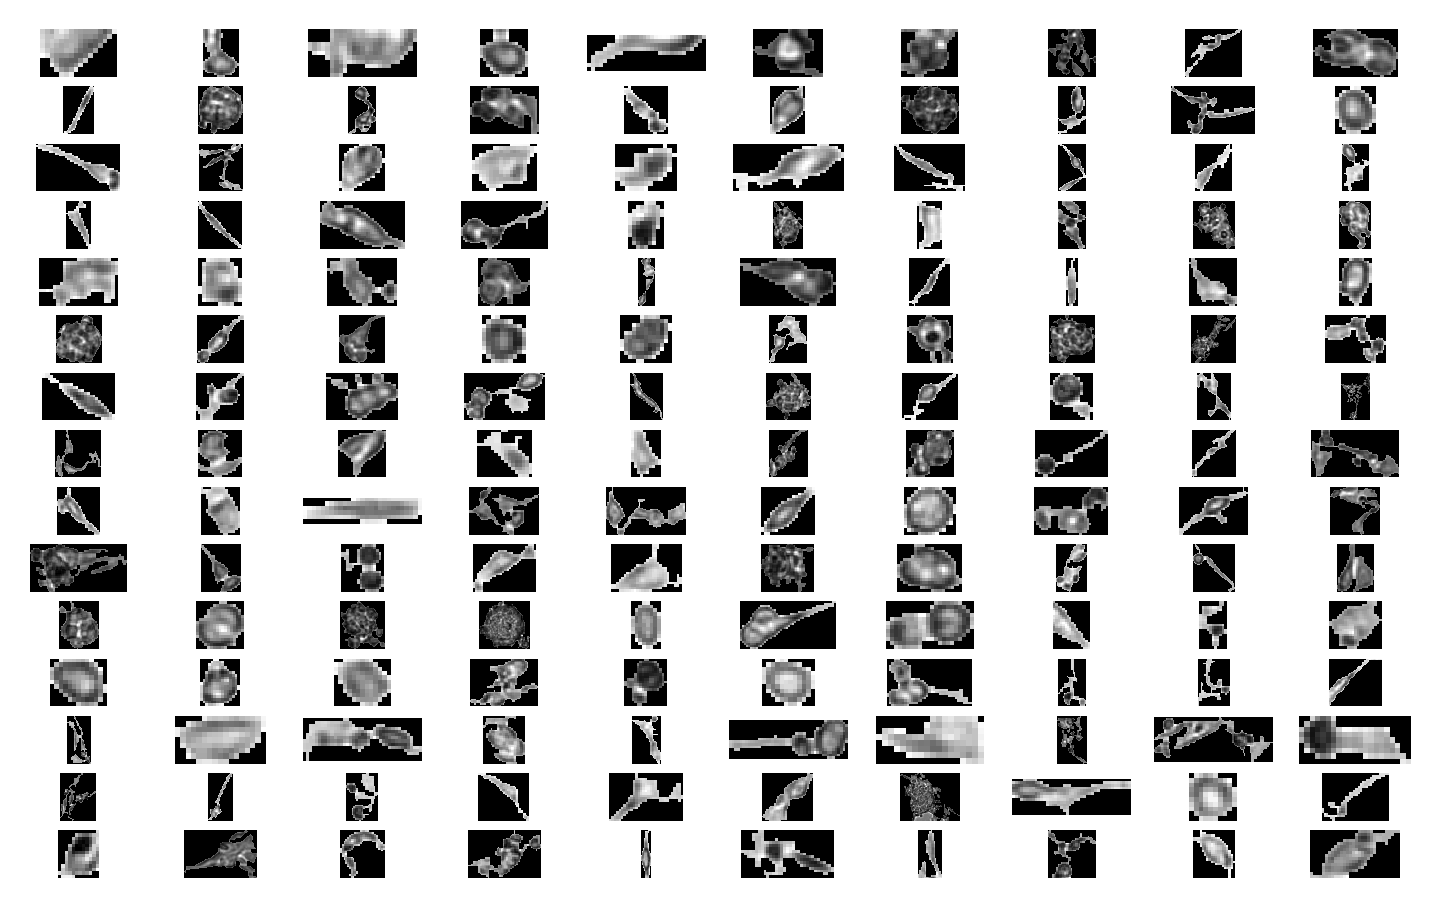

Class 1, with 65 ROIs:


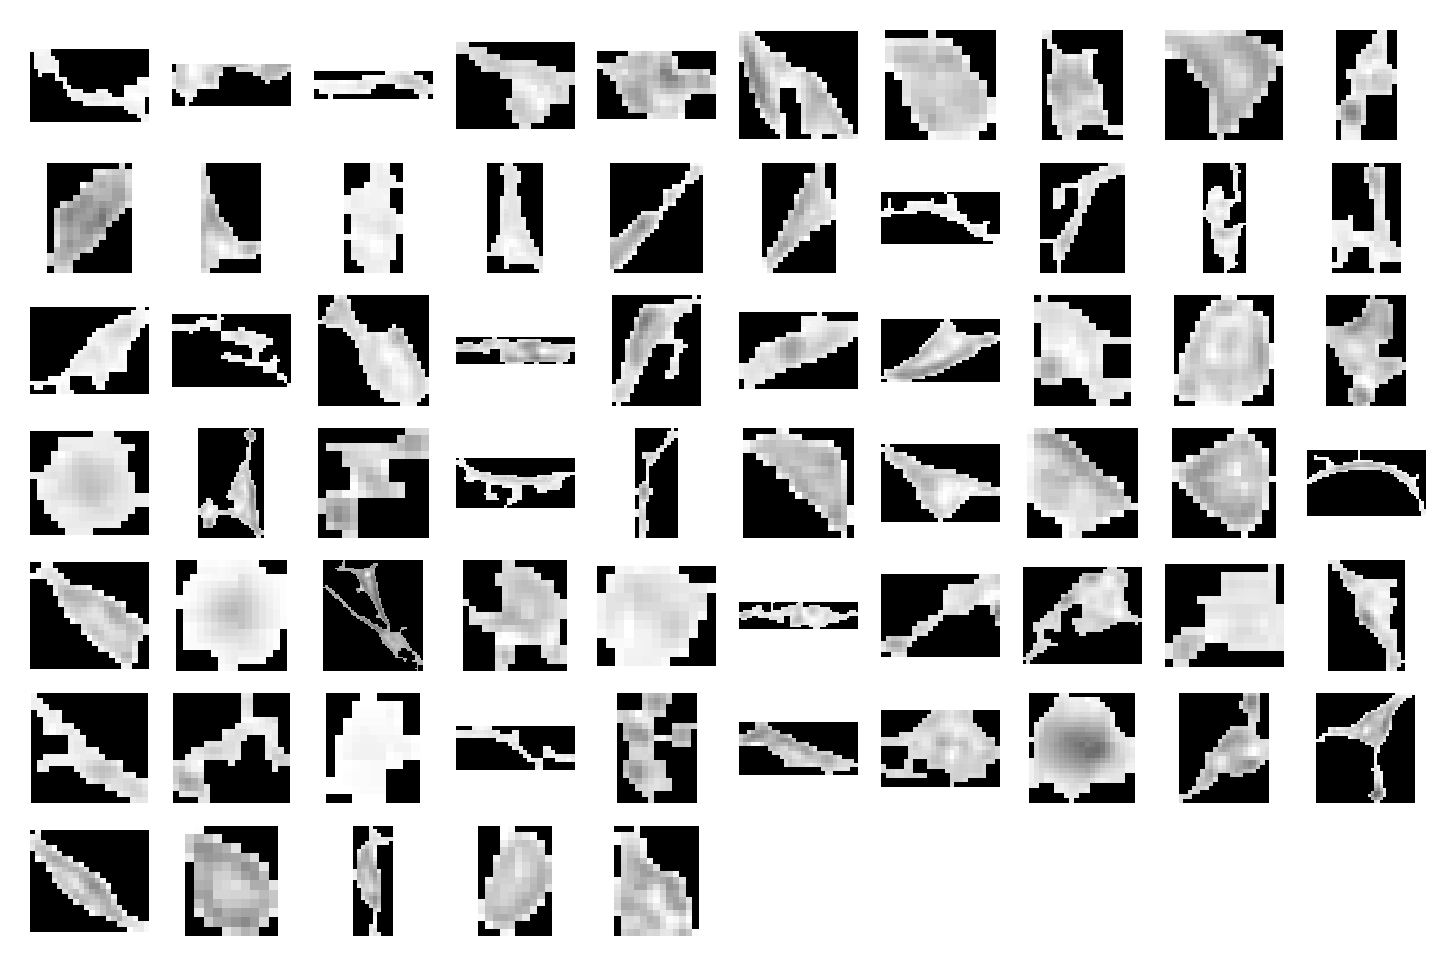

In [6]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


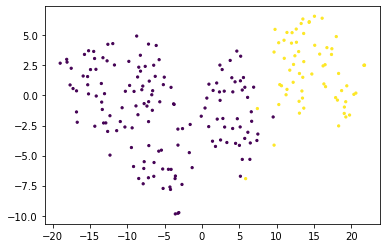

In [7]:
display_tsne(df)

# Experiment w/ multi-Otsu

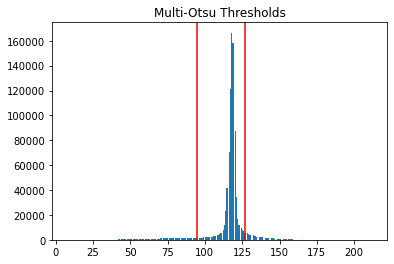

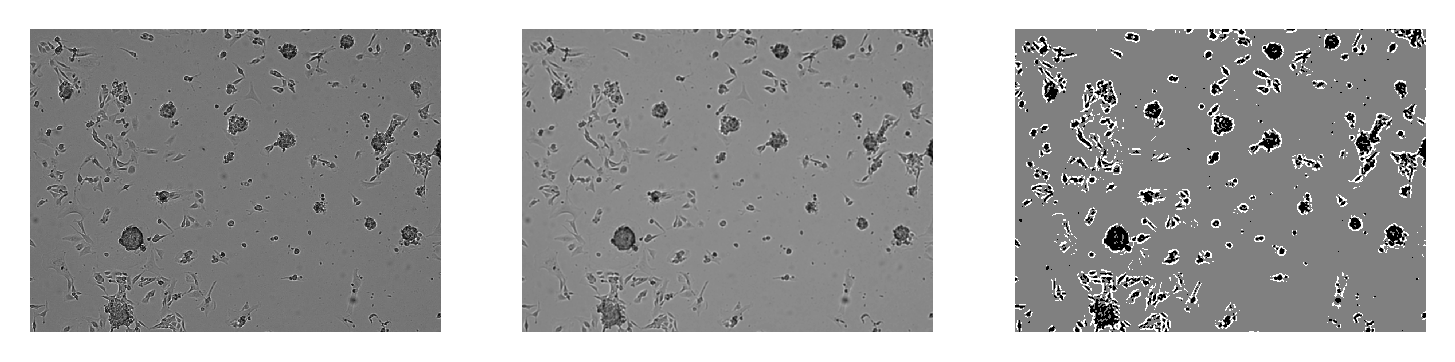

In [8]:
blurred = cv2.GaussianBlur(raw_image,(5,5),cv2.BORDER_DEFAULT)
thresholds = threshold_multiotsu(blurred)
multi_otsu_regions = np.digitize(blurred, bins=thresholds)

plt.hist(blurred.ravel(), bins=255)
plt.title('Multi-Otsu Thresholds')
for thresh in thresholds:
    plt.axvline(thresh, color='r')

display_image_array([raw_image, blurred, multi_otsu_regions],
                    columns=3, dpi=300)

# Classify cells on adherent and suspension images

Class 0: 107 (64.07%)
Class 1: 60 (35.93%)


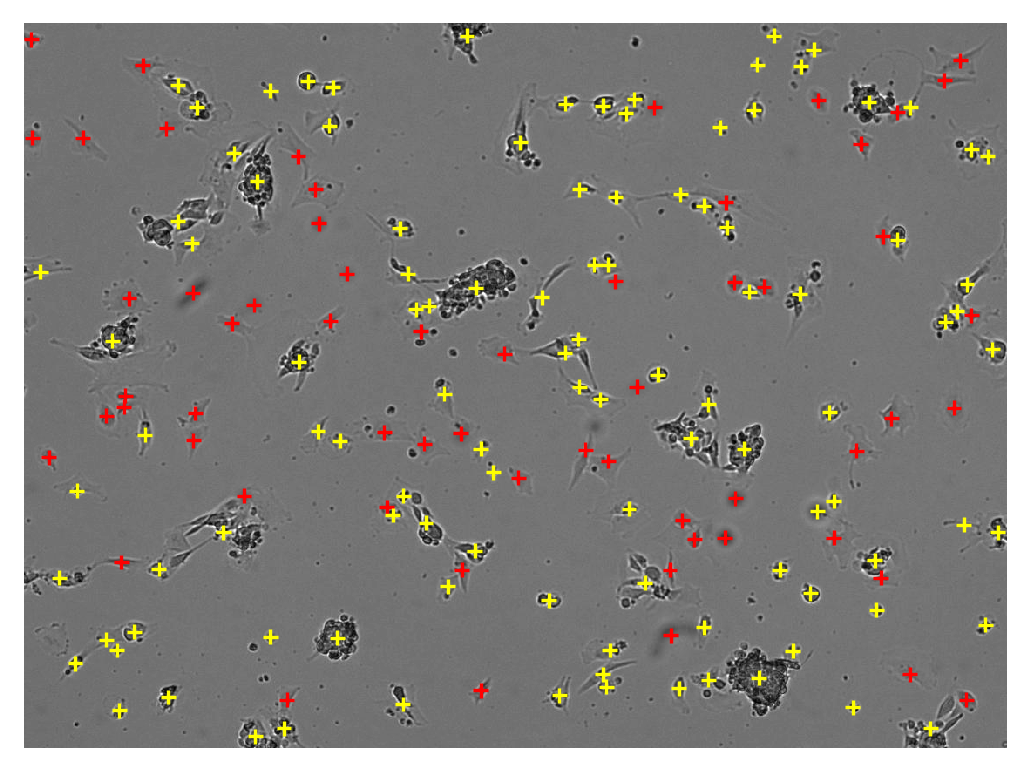

In [9]:
raw_image = cv2.imreadmulti('source_images/Adherent.tif')[1][0]
df, masks = extract_features(raw_image, thresh_ks, C, close_ks)
df = process_features(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 107 ROIs:


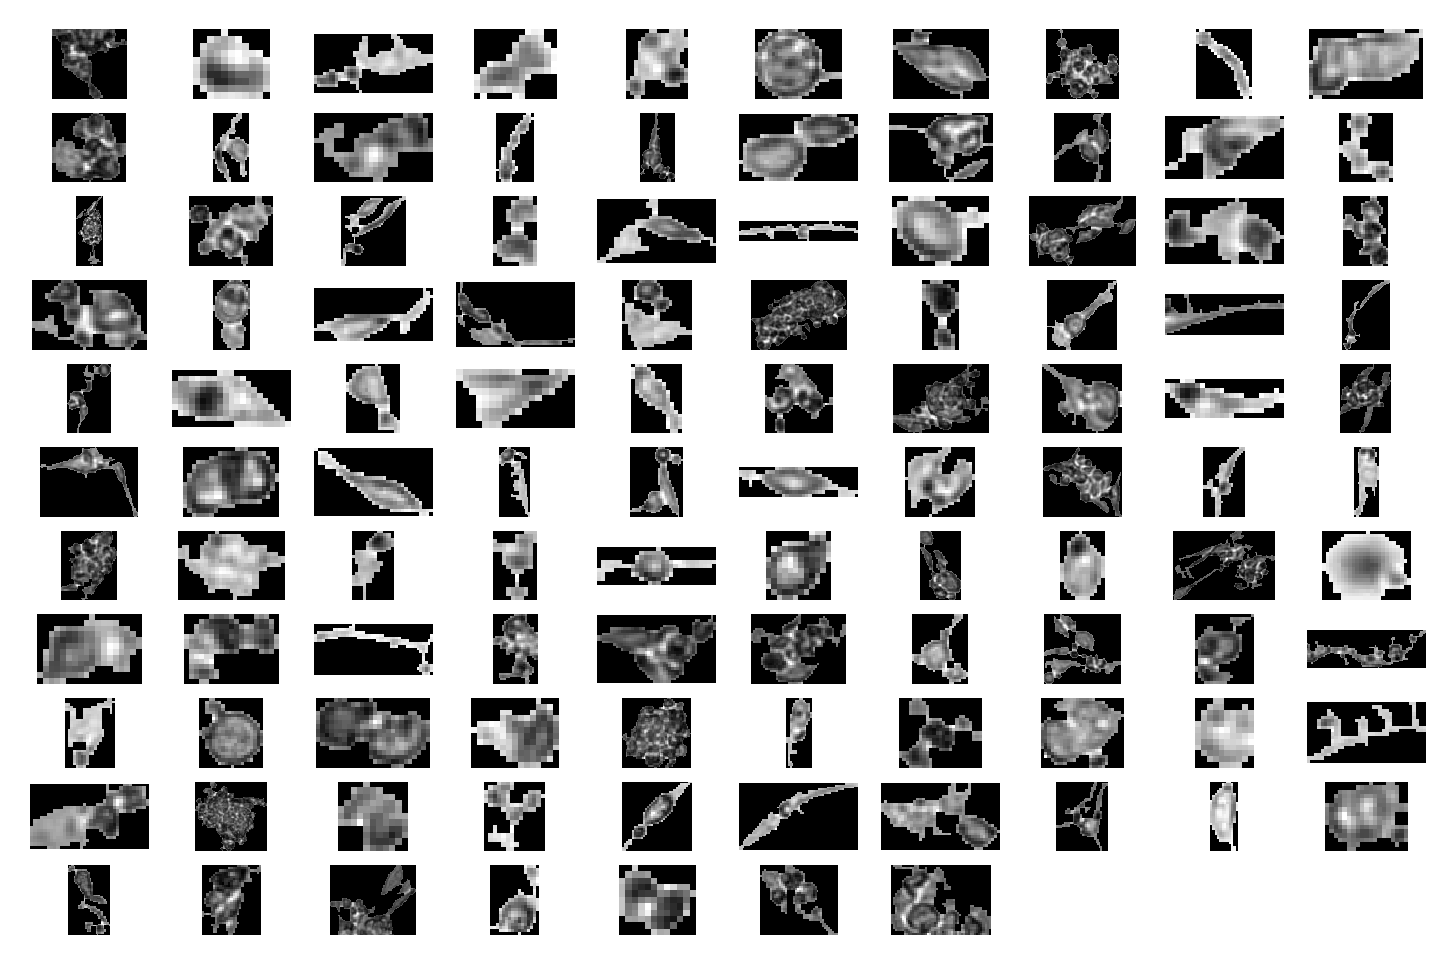

Class 1, with 60 ROIs:


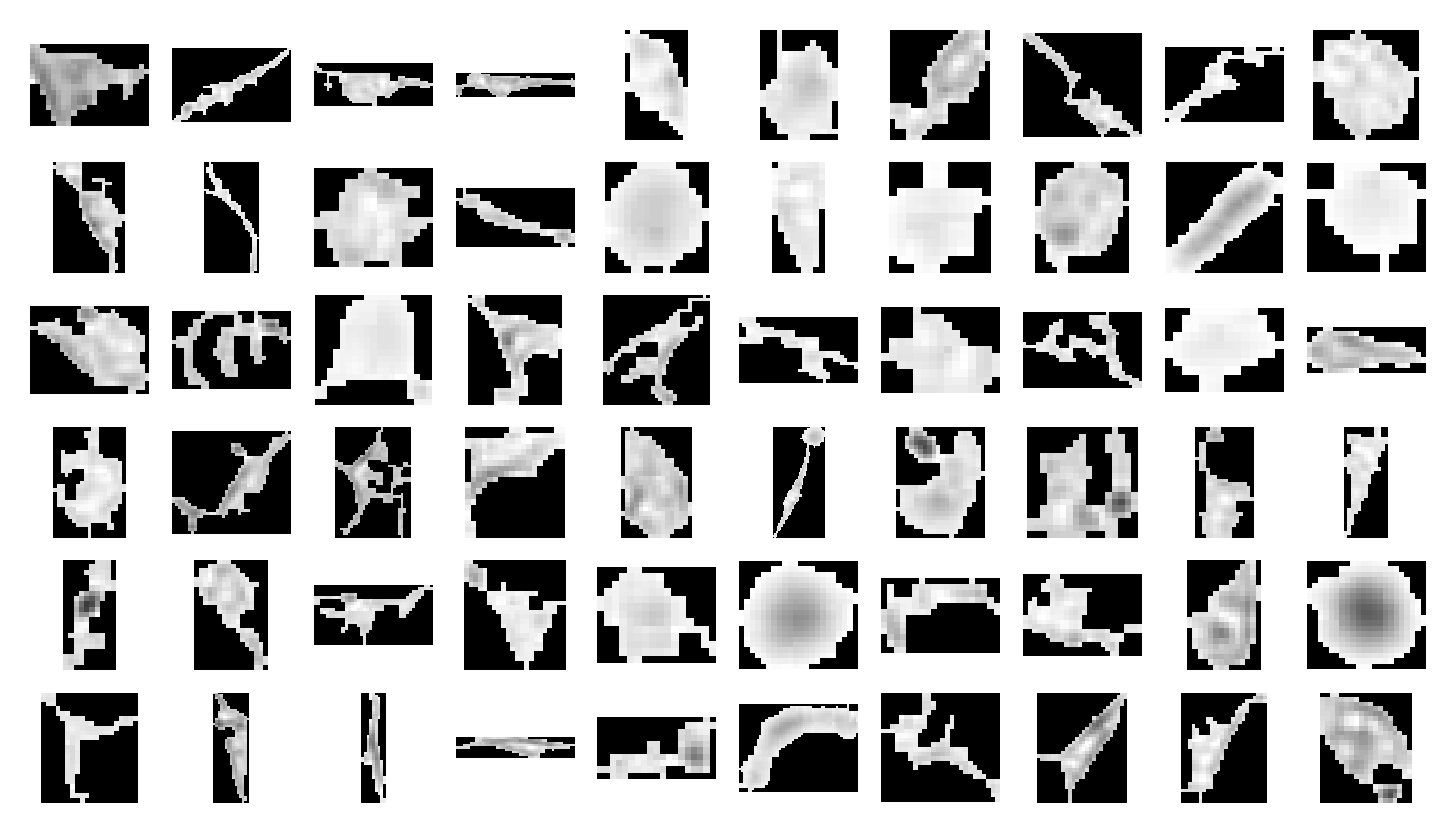

In [10]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


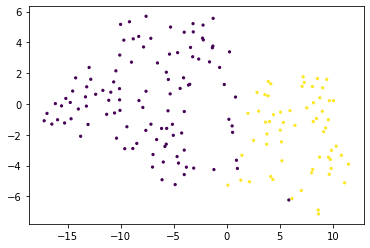

In [11]:
display_tsne(df)

Class 0: 96 (57.83%)
Class 1: 70 (42.17%)


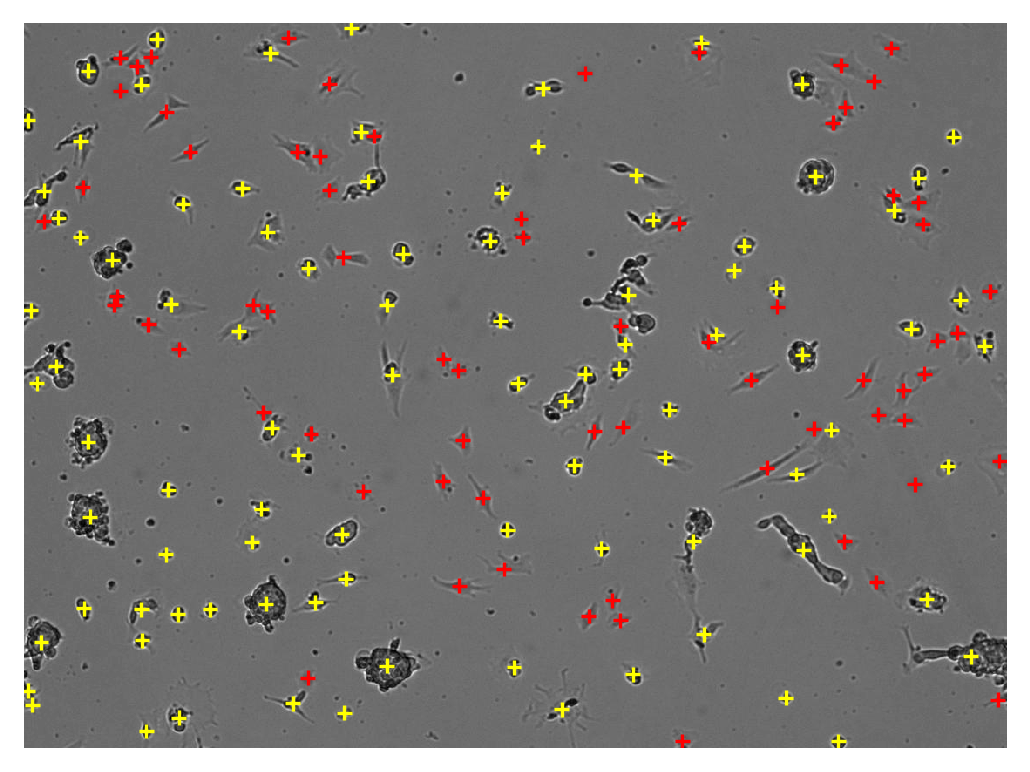

In [12]:
raw_image = cv2.imreadmulti('source_images/Suspension.tif')[1][0]
df, masks = extract_features(raw_image, thresh_ks, C, close_ks)
df = process_features(df)
labels = kmeans.predict(df)
display_classifications(raw_image, df.index, labels)

Class 0, with 96 ROIs:


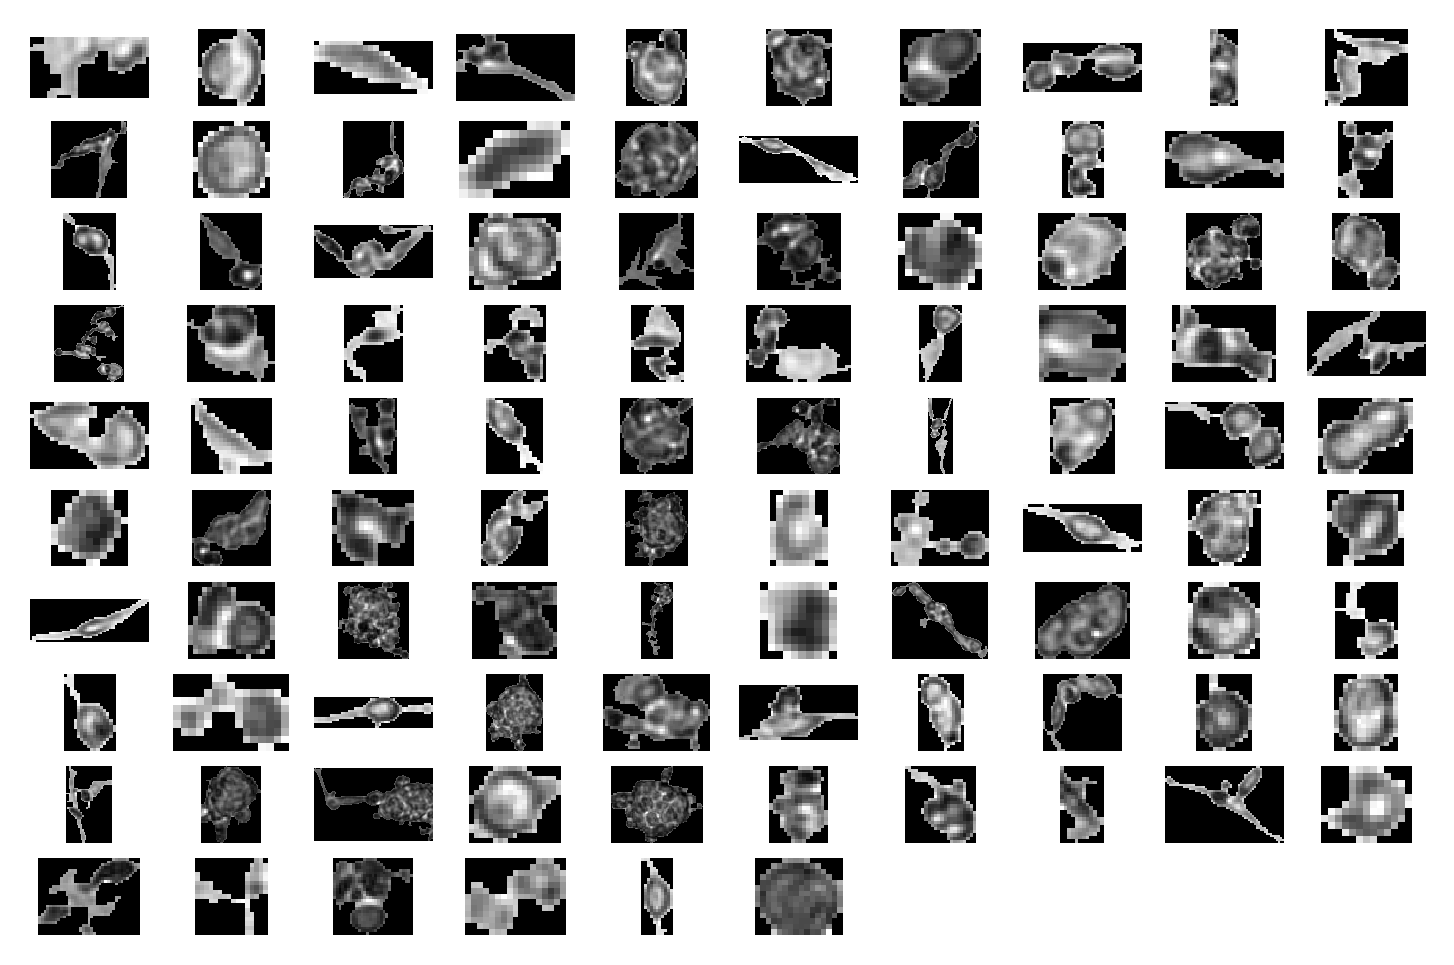

Class 1, with 70 ROIs:


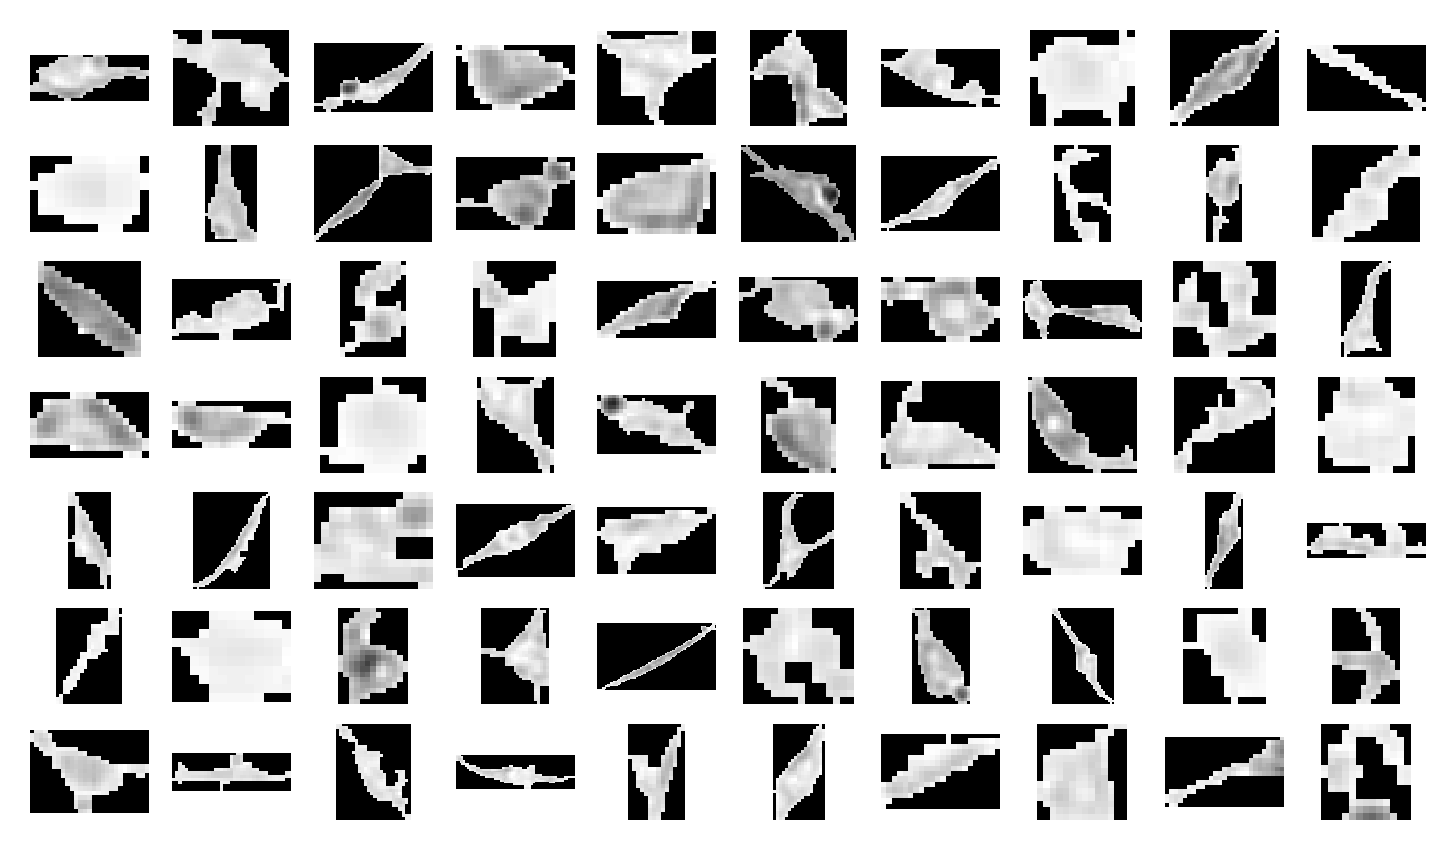

In [13]:
display_rois(raw_image, masks, labels)

/Users/peteyeh/miniconda3/envs/jupyter/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


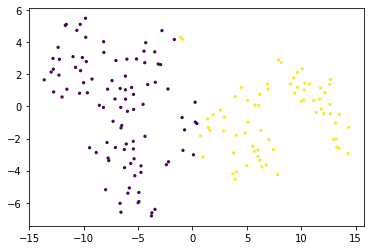

In [14]:
display_tsne(df)